In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


4423680/4422102 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


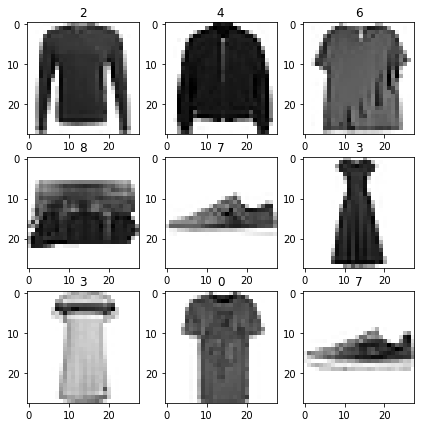

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

plt.figure(figsize=(7, 7))
for j in range(9):
    i = np.random.randint(0, 10000)
    plt.subplot(330 + 1 + j)
    plt.imshow(trainX[i], cmap='gray_r')
    plt.title(trainY[i])
plt.show()

In [4]:
trainX = [image/255 for image in trainX]
testX = [image/255 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Model (Resnet Like)

In [5]:
def custom_resnet_block(input_layer, filters, upsample=False, resnet=True):
    x = input_layer
    if resnet==True:
        x = tensorflow.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = tensorflow.keras.layers.Activation('relu')(x)
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

        x = tensorflow.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

        # Skip Connection
        x = tensorflow.keras.layers.Add()([x, input_layer])
    
    if upsample==True:
        x = tensorflow.keras.layers.UpSampling2D(size=2)(x)
        x = tensorflow.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = tensorflow.keras.layers.Activation('relu')(x)
    return x

In [6]:
low_quality_image = tensorflow.keras.layers.Input(shape=(64, 64, 3))

first = tensorflow.keras.layers.Conv2D(64, kernel_size=9, strides=1, padding='same')(low_quality_image)
first = tensorflow.keras.layers.Activation('relu')(first)

x = custom_resnet_block(first, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)

x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)

x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)

x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)

y = tensorflow.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
y = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(y)
y = tensorflow.keras.layers.Add()([y, first])

z = custom_resnet_block(y, 256, True, False)
z = custom_resnet_block(z, 256, True, False)

z = tensorflow.keras.layers.Conv2D(3, kernel_size=9, strides=1, padding='same')(z)
high_quality_image = tensorflow.keras.layers.Activation('tanh')(z)

In [7]:
generator_network = tensorflow.keras.models.Model(inputs=low_quality_image, outputs=high_quality_image)
print (generator_network.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       activation[0][0]                 
______________________________________________________________________________________________

# Discriminator Network

In [8]:
def custom_d_block(input_layer, filters, strides, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn==True:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

In [9]:
high_quality_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

x = custom_d_block(high_quality_input, 64, 1, False)
x = custom_d_block(x, 64, 2, True)
x = custom_d_block(x, 128, 1, True)
x = custom_d_block(x, 128, 2, True)
x = custom_d_block(x, 256, 1, True)
x = custom_d_block(x, 256, 2, True)
x = custom_d_block(x, 512, 1, True)
x = custom_d_block(x, 512, 2, True)

x = tensorflow.keras.layers.Dense(1024)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

real_vs_fake_patch = tensorflow.keras.layers.Dense(1, activation='sigmoid')(x)

In [10]:
discriminator_network = tensorflow.keras.models.Model(inputs=high_quality_input, outputs=real_vs_fake_patch)
print (discriminator_network.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 128, 128)     7385

In [11]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Pre Trained VGG feaures

In [15]:
high_quality_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

pre_trained_vgg = tensorflow.keras.applications.VGG19(weights='imagenet')
pre_trained_vgg.outputs = [pre_trained_vgg.get_layer('block3_conv4').output]
pre_trained_image_feautures = pre_trained_vgg(high_quality_input)

custom_vgg = tensorflow.keras.models.Model(inputs=high_quality_input, outputs=pre_trained_image_feautures)
print (custom_vgg.summary())

ValueError: ignored

In [14]:
pre_trained_vgg.layers

In [13]:
pre_trained_vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# SR-GAN

In [ ]:
low_quality_image = tensorflow.keras.layers.Input(shape=(64, 64, 3))
high_quality_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

fake_high_quality_image = generator_network(low_quality_image)
fake_high_quality_features = custom_vgg(fake_high_quality_image)

discriminator_network.trainable=False

d_output = discriminator_network(fake_high_quality_image)

sr_gan = tensorflow.keras.models.Model(inputs=[low_quality_image, high_quality_input],\
                                                   outputs=[d_output, fake_high_quality_features])

print (sr_gan.summary())

NameError: name 'custom_vgg' is not defined

# Compiling Models

In [ ]:
sr_gan.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[0.001, 1], optimizer=adam_optimizer)

NameError: name 'sr_gan' is not defined

# Define Data Generators

In [ ]:
indices = [i for i in range(0, len(trainX))]

def get_batches_of_domains(batch_size):
    domain_A_images = []
    domain_B_images = []
    return domain_A_images, domain_B_images

def show_generator_results(generator_network_AB, generator_network_BA):
    domain_A_images, domain_B_images = get_batches_of_domains(10)
    
    fake_B_images = generator_network_AB(domain_A_images)
    fake_A_images = generator_network_BA(domain_B_images)

    plt.figure(figsize=(7, 7))
    for j in range(5):
        i = j
        plt.subplot(550 + 1 + j)
        plt.imshow(fake_A_images[i,:,:,-1], cmap='gray')
    plt.show()
    
    plt.figure(figsize=(7, 7))
    for j in range(5):
        i = j
        plt.subplot(550 + 1 + j)
        plt.imshow(fake_B_images[i,:,:,-1], cmap='gray')
    plt.show()
    return

# Training GAN

In [ ]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 500

for i in range(0, epochs):
    if (i%10 == 0):
        op = show_generator_results(generator_network_AB, generator_network_BA)
        #print (op)
    for j in range(steps):
        domain_A_images, domain_B_images = get_batches_of_domains(batch_size)

        fake_patch = np.zeros((batch_size, 16, 16, 1))
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        fake_B_images = generator_network_AB(domain_A_images)
        fake_A_images = generator_network_BA(domain_B_images)
        
        # Updating Discriminator A weights
        discriminator_network_A.trainable=True
        loss_d_real_A = discriminator_network_A.train_on_batch(domain_A_images, real_patch)
        loss_d_fake_A = discriminator_network_A.train_on_batch(fake_A_images, fake_patch)
        
        loss_d_A = np.add(loss_d_real_A, loss_d_fake_A)/2.0
        
        # Updating Discriminator B weights
        discriminator_network_B.trainable=True
        loss_d_real_B = discriminator_network_B.train_on_batch(domain_B_images, real_patch)
        loss_d_fake_B = discriminator_network_B.train_on_batch(fake_B_images, fake_patch)
        
        loss_d_B = np.add(loss_d_real_B, loss_d_fake_B)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        
        discriminator_network_A.trainable=False
        discriminator_network_B.trainable=False
        
        # Updating Generator weights
        loss_g = cycle_gan.train_on_batch([domain_A_images, domain_B_images],\
                    [real_patch, real_patch, domain_A_images, domain_B_images, domain_A_images, domain_B_images])
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, DA-Loss:%.3f, DA-Acc:%.3f, DB-Loss:%.3f, DB-Acc:%.3f, G-Loss:%.3f"\
                   %(i,j,loss_d_A[0],loss_d_A[1]*100,loss_d_B[0],loss_d_B[1]*100,loss_g[0]))
            

AssertionError: Could not compute output Tensor("activation_8/Tanh:0", shape=(None, 256, 256, 3), dtype=float32)